In [2]:
import sys
sys.path.append('./ThirdParty')

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from skimage import io
from PIL import Image
from scipy.ndimage import zoom, gaussian_filter
from tqdm import tqdm

from ThirdParty.romatch import roma_outdoor
from ThirdParty.romatch.utils.utils import get_tuple_transform_ops

from utils.utils import read_csv, create_csv
from utils.vis2D import plot_images, plot_matches, save_plot

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.backends.mps.is_available():
    device = torch.device('mps')

In [3]:
# Chest
# im1_path=r'C:\Users\deschweiler\Documents\KneeMRI_PatellofemoralMeasurements\data\ChestX-ray14_fullsize\preprocessed\images_001\images\00000006_000.png'
# im2_path=r'C:\Users\deschweiler\Documents\KneeMRI_PatellofemoralMeasurements\data\ChestX-ray14_fullsize\preprocessed\images_001\images\00000007_000.png'

# Scoliosis
# im1_path=r'D:\data\Scoliosis_UKA\scoliosis7.png'
# im2_path=r'D:\data\Scoliosis_UKA\scoliosis5.png'

# Feet AP
# im1_path = r'D:\data\DennisFeetX\annotated_AP_Eneko\Right\13\13_SER_0000.jpg'
# im2_path = r'D:\data\DennisFeetX\annotated_AP_Eneko\Right\47\47_SER_0002.jpg'

# Feet Lat
# im1_path = r'D:\data\UKAFeetX\annotated_lateral_Eneko\facing_left\13\13_SER_0002_1.jpg'
# im2_path = r'D:\data\UKAFeetX\annotated_lateral_Eneko\facing_left\25\25_SER_0001.jpg'

# Knee
# im1_path = r'D:\data\UKAKneeX\9176032701-ap_lat\images\0.png'
# im2_path = r'D:\data\UKAKneeX\91922005005-right\images\0.png'

# Patella
# im1_path = r'D:\data\UKAKneeX\9176032701-patella-right\images\0.png'
# im2_path = r'D:\data\UKAKneeX\9154181106-patella-right_left\images\0.png'

# Patella Implant
im1_path = r'E:\data\UKAKneeX\AXIAL_LEFT\1000000001265252_9191784602\1000000001265252_9191784602_AXIAL_LEFT_image.jpg'
im2_path = r'E:\data\UKAKneeX\AXIAL_EXTRA_LEFT\1000000001553805_0000728815\1000000001553805_0000728815_AXIAL_EXTRA_LEFT_image.jpg'

# Shoulder
# im1_path = r'D:\data\UKAShoulderX\EXTERNAL_ROT\LEFT\4\4_SER_0002.jpg'
# im2_path = r'D:\data\UKAShoulderX\EXTERNAL_ROT\LEFT\20\20_SER_0000.jpg'


#kpt_file = r'C:\Users\deschweiler\Documents\KneeMRI_PatellofemoralMeasurements\data\ChestX-ray14\no_finding=1_followup_num=0_view_position=PA\images_001\landmarks\00000006_000_landmarks.csv'
#save_path = ''

In [4]:
roma_model = roma_outdoor(device=device, coarse_res=560, upsample_res=1024)

c:\Users\DEschweiler\AppData\Local\miniconda3\envs\lightning2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\DEschweiler\AppData\Local\miniconda3\envs\lightning2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using coarse resolution (560, 560), and upsample res (1024, 1024)


# Feature Similarity Heatmap

#### Load image data and extract features

In [5]:
im_A, im_B = Image.open(im1_path).convert("RGB"), Image.open(im2_path).convert("RGB")
with torch.no_grad():
    test_transform = get_tuple_transform_ops(
                        resize=(560, 560), normalize=True, clahe = False
                    )
    im_A, im_B = test_transform((im_A, im_B))
    im_batch = {"im_A": im_A[None].to(device), "im_B": im_B[None].to(device)}

    feature_pyramid = roma_model.extract_backbone_features(im_batch)

#### Concatenate feature pyramid

In [6]:
feature_maps = None
for scale, features in feature_pyramid.items():

    scaled_features = torch.nn.functional.interpolate(features, size=(560, 560), mode='nearest')
    
    if feature_maps is None:
        feature_maps = scaled_features
    else:
        feature_maps = torch.concatenate((feature_maps, scaled_features), dim=1)

    print(scale)
    print(scaled_features.shape)

1
torch.Size([2, 64, 560, 560])
2
torch.Size([2, 128, 560, 560])
4
torch.Size([2, 256, 560, 560])
8
torch.Size([2, 512, 560, 560])
16
torch.Size([2, 1024, 560, 560])


#### Choose a coordinate and calculate distance to all positions within the image

In [82]:
# ChestX 6/7
#chosen_coord = (50,290)
#chosen_coord = (320,190)
#chosen_coord = (470,60)
#chosen_coord = (500,60)
#chosen_coord = (405,150)

# Scoliosis
#chosen_coord = (230,280)

# Feet AP 13/30
#chosen_coord = (155,350)
#chosen_coord = (270,310)
#chosen_coord = (340,260)

# Feet Lat 13/25
#chosen_coord = (245,75)
#chosen_coord = (255,490)
#chosen_coord = (125,155)

# Knee
#chosen_coord = (225,110)
#chosen_coord = (270,200)
#chosen_coord = (440,210)

# Patella
#chosen_coord = (250,280)
#chosen_coord = (160,150)
#chosen_coord = (450,300)

# Patella Extra
# chosen_coord = (267,300)
# chosen_coord = (280,400)
chosen_coord = (180,400)

# Shoulder
#chosen_coord = (360,250)
#chosen_coord = (520,310)
#chosen_coord = (330,330)


distance = feature_maps[1,...]- feature_maps[0,:,chosen_coord[0]:chosen_coord[0]+1, chosen_coord[1]:chosen_coord[1]+1]
distance = torch.sqrt(distance **2)
distance = torch.sum(distance, dim=0, keepdim=False)
distance -= distance.min()
distance /= distance.max() 

#### Visualize results

In [83]:
im_A_PIL = transforms.ToPILImage()((im_A-im_A.min())/(im_A.max()-im_A.min()))
im_B_PIL = transforms.ToPILImage()((im_B-im_B.min())/(im_B.max()-im_B.min()))

In [84]:
heatmap_np = (1-distance).numpy(force=True)
heatmap_np = gaussian_filter(heatmap_np, sigma=8)

colormap = plt.get_cmap('magma')
heatmap = colormap(heatmap_np)
heatmap = (heatmap[...,:3]*255).astype(np.uint8)
heatmap_PIL = Image.fromarray(heatmap).convert("RGBA")
heatmap_PIL.putalpha(Image.fromarray((heatmap_np * 180).astype(np.uint8)))

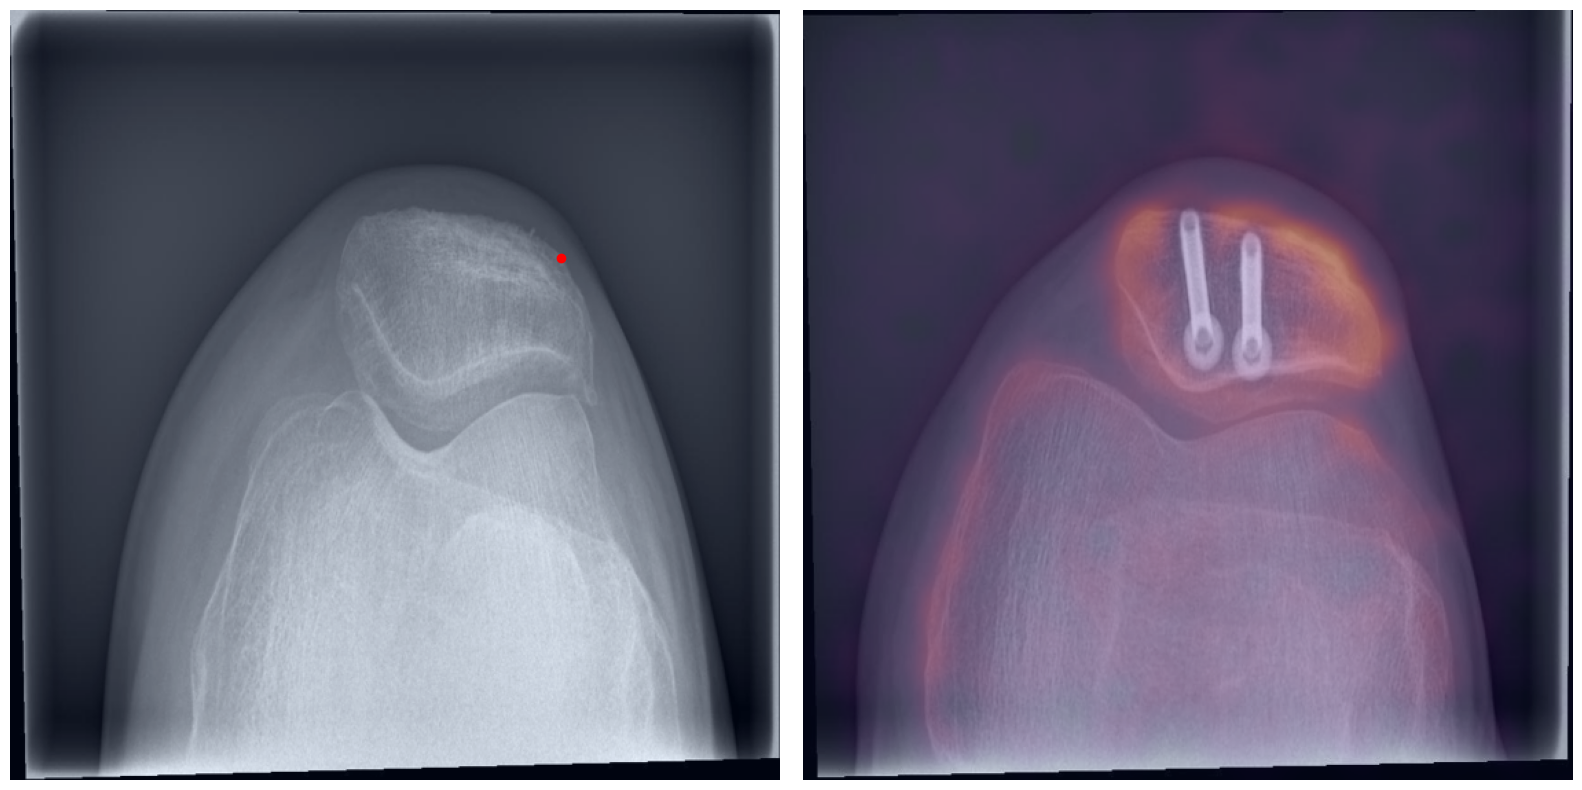

In [86]:
overlay = Image.alpha_composite(im_B_PIL.convert("RGBA"), heatmap_PIL)
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].imshow(im_A_PIL, cmap='gray')
ax[1].imshow(overlay, cmap='gray')
#ax[2].imshow(im_B_PIL, cmap='gray')
ax[0].scatter(chosen_coord[1], chosen_coord[0], c='red')
ax[0].axis('off')
ax[1].axis('off')
#ax[2].axis('off')
plt.tight_layout()

#### Assess feature ambiguity

In [ ]:
# Flatten and normalize the heatmap values
distance_flat = distance.flatten().numpy(force=True)
distance_flat = (distance_flat - distance_flat.min()) / (distance_flat.max() - distance_flat.min())

# Calculate histogram of values and normalize it to create a probability distribution
hist, _ = np.histogram(distance_flat, bins=256, density=True)

# Calculate gini coefficient
gini_coeff = gini(hist)
print(f"Gini coefficient: {gini_coeff:.4f}")

#### Loop ambiguity assessment for each position to identify robust landmark spots

In [201]:
# downscale feature maps for better runtimes
feature_maps_downscaled = feature_maps[:,:,::4,::4]

# determine all positions
coords_all_x, coords_all_y = np.indices(feature_maps_downscaled.shape[2:4])
coords_all_x, coords_all_y = coords_all_x.flatten(), coords_all_y.flatten()

In [ ]:
def entropy(prob_tensor):
    prob_tensor = prob_tensor[prob_tensor > 0]  # Avoid log(0)
    return -torch.sum(prob_tensor * torch.log(prob_tensor))

entropy_map = torch.zeros(feature_maps_downscaled.shape[2:4])
for chosen_coord_x, chosen_coord_y in tqdm(zip(coords_all_x, coords_all_y), total=len(coords_all_x)):

    # calculate feature distance to all other positions 
    distance_tmp = feature_maps_downscaled[1,...] - feature_maps_downscaled[0,:,chosen_coord_x:chosen_coord_x+1, chosen_coord_y:chosen_coord_y+1]
    distance_tmp = torch.sum(distance_tmp**2, axis=0) # leaving out sqrt for euclidean distance calculation to improve runtime

    # Calculate histogram of values and normalize it to create a probability distribution
    hist_tmp = torch.histc(distance_tmp, bins=100)
    hist_tmp = hist_tmp / torch.sum(hist_tmp)  # Normalize to get probabilities

    # Compute the gini coefficient
    entropy_tmp = entropy(hist_tmp)

    # save current gini coefficient
    entropy_map[chosen_coord_x, chosen_coord_y] = entropy_tmp

In [ ]:
entropy_map_vis = entropy_map.numpy(force=True)
entropy_map_vis = entropy_map_vis.clip(3.5,4)
entropy_map_vis = zoom(entropy_map_vis, [e/s for s,e in zip(entropy_map_vis.shape, (560, 560))], order=3)
entropy_map_vis = gaussian_filter(entropy_map_vis, sigma=8)

colormap = plt.get_cmap('magma')
entropy_map_vis = entropy_map_vis - entropy_map_vis.min()
entropy_map_vis /= entropy_map_vis.max()
entropy_map_vis = colormap(entropy_map_vis)
entropy_map_vis_PIL = Image.fromarray((entropy_map_vis*255).astype(np.uint8)).convert('RGBA')
entropy_map_vis_PIL.putalpha(Image.fromarray((entropy_map_vis*180).astype(np.uint8)).convert('L'))
entropy_overlay = Image.alpha_composite(im_A_PIL.convert("RGBA"), entropy_map_vis_PIL)

plt.imshow(entropy_overlay, cmap='gray')